# Fitting the prior $p(F^\text{R})$

**IMPORTANT**: We can actually get $p(F^\text{R}, \hat F^\text{R}, \hat T)$ from the two databases, but **here we only fit $p(F^\text{R}, \hat F^\text{R})$, which gives us the lengthscale \lambda^F** needed later. See `bandwidth.py` for use of $\hat T$!

## TIMIT-derived datasets

We combine data from 2 datasets:
- TIMIT: wav and phone transcriptions
- VTRFormants: manually verified F1-3 tracks (though interpolated). A subset of TIMIT. 324 train files, 192 test files.

We can't use TIMIT-voiced (another TIMIT subset) to ensure that we are only looking at voiced speech because they only overlap in 10 samples. ~~So we use Praat's heuristics (the pulses) to determine whether there is voiced speech.~~ This is quite brittle because of boundary effects -- so we just use the phonetic information and only consider vowel events for simplicity (it's just a prior after all). In this we follow Mehta (2012), although much more restricted (they only filter out silence regions and accept consonants etc.)

### VTRFormants

Citing from the README file:

> Note that only the first three elements of these vectors (F1, F2, F3) are manually corrected.

This is why we only use the first three $F$ and not the $B$ values, to be maximally safe. However, to bootstrap **pitch period** trajectories we will average the true and estimated $F$ over these pitch periods, which themselves are only estimated by Praat -- so this introduces a bit error in the ground truth.

Each frame is 10 msec:

> Note also that since interpolation was used, VTR/formant tracks are placed in silence intervals where no VTR exists. When evaluating formant trackers, these values should probably be excluded from the evaluation.

That is exactly what we do.

## Data cleaning

To simplify the analysis, we only compare formants during vowel events as identified by the original TIMIT database.

And we only run the Praat analysis (both pulses and formants) during these events to get clean estimates, because at the boundaries there can be strong jumps in Praat's F1-F3 formant tracks.

We also don't correct for Praat's $\hat T$ (has ~7% relative error) and thus take Praat's estimated pitch periods at face value.

We can evaluate formant tracks and ground truth anywhere using interpolation (this is what both VTRFormants and Praat do anyway).

## Results

The Praat estimates are broadly very good -- we also only measure over vowels so the performance out there in the wild should be quite a bit lower. But our estimates for Praat's errors are quite large -- around 10 - 30% relative error. Why?

Because sometimes Praat "jumps" in its F2 assignment -- assigning its F2 to the real F3 and its F3 to some F4 thing (which is not in the database). The real F2 is forgotten, and these jumps happen enough to affect the MVN error characterization significantly. For example, all errors point to overestimation and are positively correlated -- this describes jump errors. Nevertheless, it is good that our prior is ready to deal with this situation -- although imperfectly, because a MVN cannot really model jump behavior.

## Processing TIMIT and VTRFormants to get the training data

In [1]:
%run init.ipy

from lib import htkio
from dgf import bijectors

from vtr.prior import formant

2022-11-08 17:03:19.740203: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


[Memory]2.9s, 0.0min    : Loading get_aplawd_training_pairs...


[Memory]17.0s, 0.3min   : Loading run_nested...
[Memory]18.5s, 0.3min   : Loading run_nested...
[Memory]19.9s, 0.3min   : Loading run_nested...
[Memory]21.3s, 0.4min   : Loading run_nested...
[Memory]21.3s, 0.4min   : Loading get_aplawd_training_pairs...


[Memory]24.8s, 0.4min   : Loading get_vtrformants_training_data...
[Memory]32.7s, 0.5min   : Loading run_nested...
[Memory]33.6s, 0.6min   : Loading run_nested...
[Memory]34.4s, 0.6min   : Loading run_nested...
[Memory]35.3s, 0.6min   : Loading run_nested...
[Memory]35.3s, 0.6min   : Loading get_vtrformants_training_data...


In [2]:
from lib.timit import *

def rand_triple():
    vtr_root = training_set(VTRFORMANTS)
    timit_root = training_set(TIMIT)
    l = list(yield_file_triples(vtr_root, timit_root))
    import random
    return random.choice(l)

triple = rand_triple()
fb_file, phn_file, wav_file = triple
triple

(PosixPath('/home/marnix/WRK/thesis/py/../data/VTRFormants/TRAIN/DR6/MSAT1/SI1073.FB'),
 PosixPath('/home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR6/MSAT1/SI1073.PHN'),
 PosixPath('/home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR6/MSAT1/SI1073.WAV'))

In [3]:
d, fs = formant.read_wav_file_and_normalize(wav_file)
t = np.arange(len(d))/fs

from lib import klatt
klatt.play(t*1000., d)

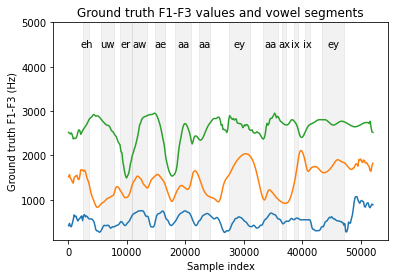

In [4]:
phn = formant.select_vowel_segments(phn_file)

def plot_vowel_segments(df, ytext):
    for start, end, label in phn.to_tuples():
        plt.axvspan(start, end, color="grey", alpha=.1)
        plt.text(start + (end - start)/2, ytext, label,
                 horizontalalignment='center',
                 verticalalignment='center')

plot_vowel_segments(phn, 4500.)
        
frame_midpoint_idx, F_true = formant.select_F_true(fb_file, fs)

plt.plot(frame_midpoint_idx, F_true)
xlabel("Sample index")
ylabel("Ground truth F1-F3 (Hz)")
title("Ground truth F1-F3 values and vowel segments")
ylim(100, 5000);

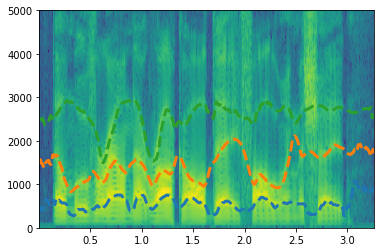

In [5]:
specgram(d, Fs=fs);
plot(frame_midpoint_idx/fs, F_true, '--', lw=3)
ylim(0, 5000);

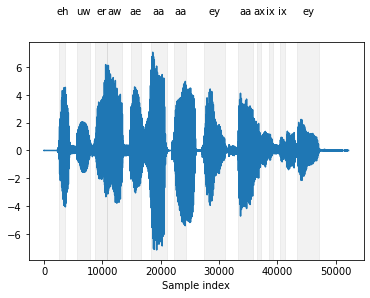

In [6]:
plot_vowel_segments(phn, 10)
plot(d)
xlabel("Sample index");

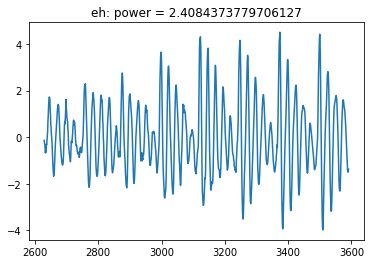

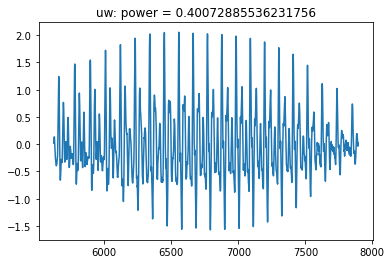

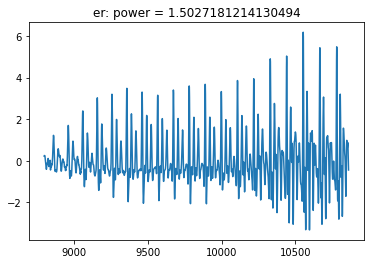

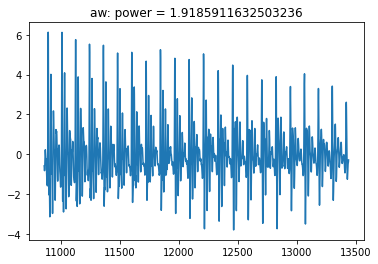

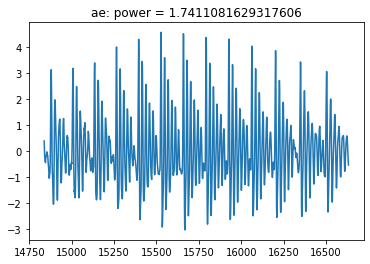

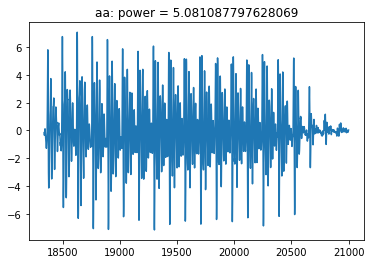

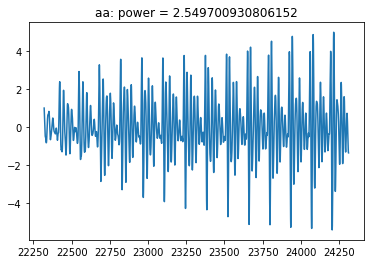

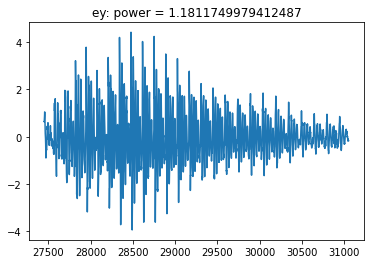

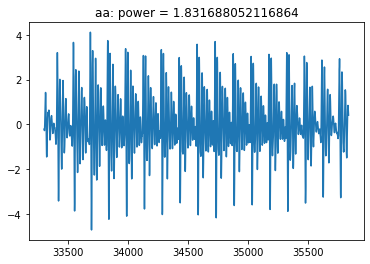

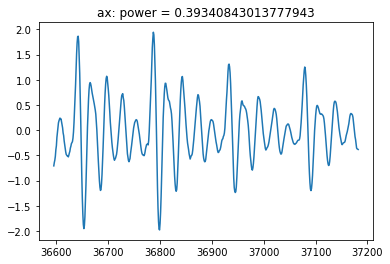

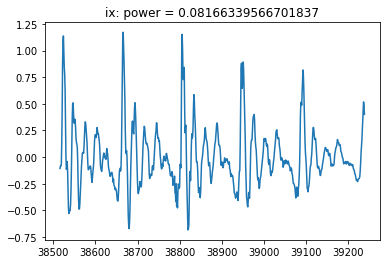

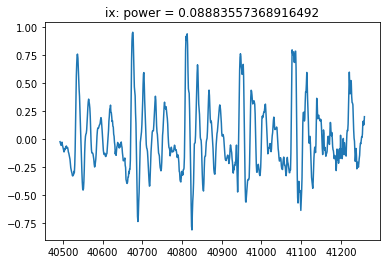

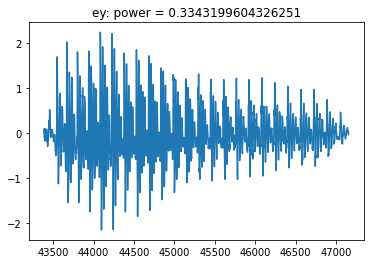

In [7]:
# Locally the power may vary, but we renormalize anyway so it doesnt matter
for start, end, label in phn.to_tuples():
    idx = range(start, end)
    segment = d[idx]
    plot(idx, segment)
    power = np.sum(segment**2)/len(segment)
    title(f'{label}: power = {power}')
    show()

**********uw**********


/home/marnix/WRK/thesis/py/vtr/prior/formant.py:90: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR6/MSAT1/SI1073.WAV: Discarding vowel `eh` segment at sample indices 2629:3592: Praat gave only 2 < 3 valid formants
  warnings.warn(


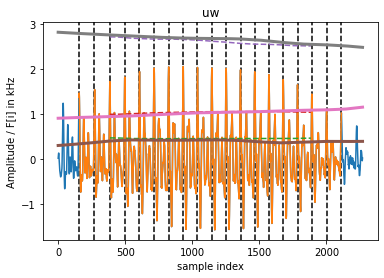

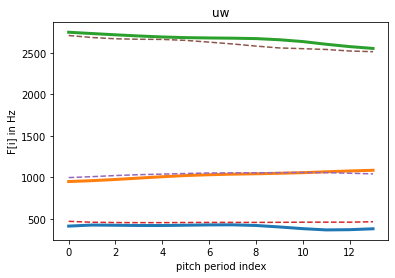

**********er**********


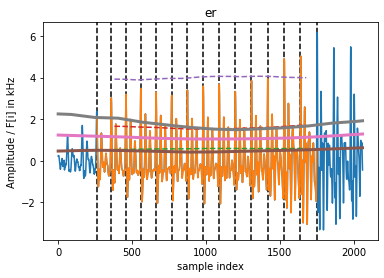

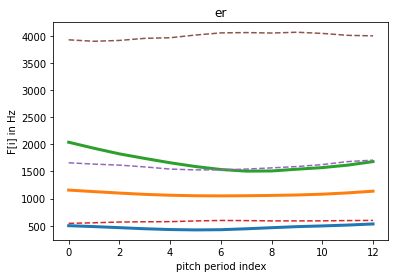

**********aw**********


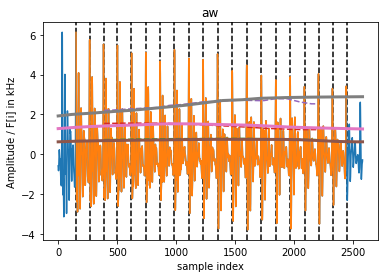

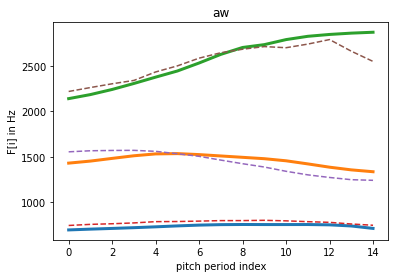

**********ae**********


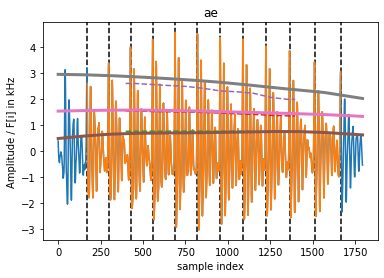

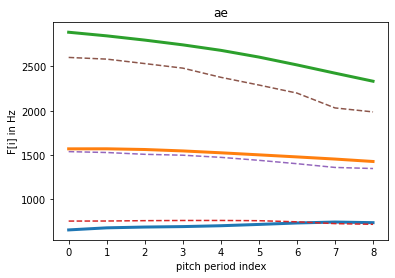

**********aa**********


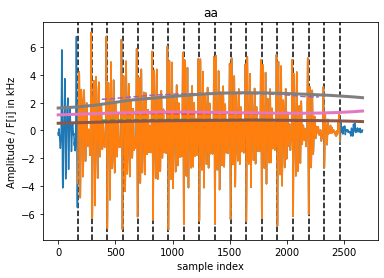

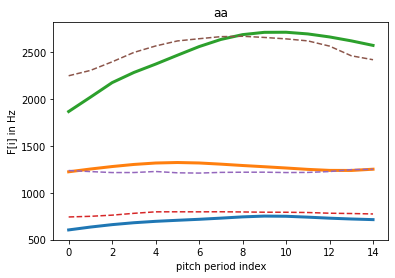

**********aa**********


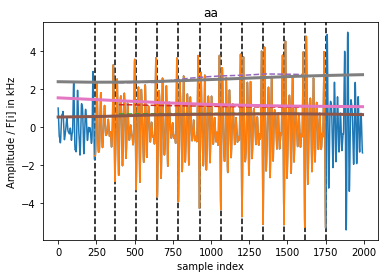

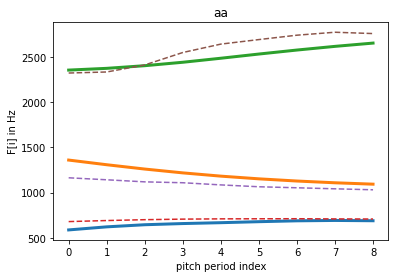

**********ey**********


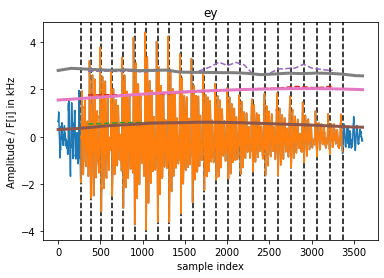

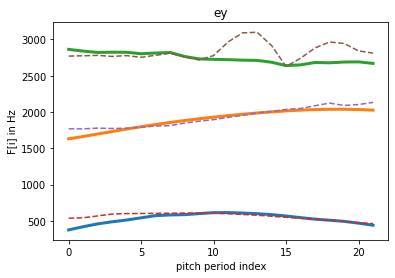

**********aa**********


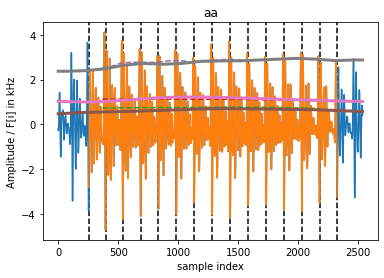

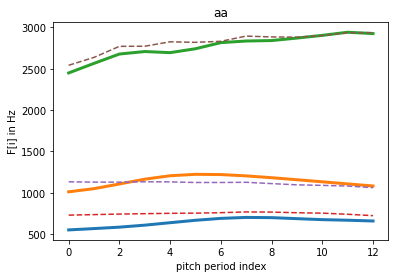

/home/marnix/WRK/thesis/py/vtr/prior/formant.py:90: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR6/MSAT1/SI1073.WAV: Discarding vowel `ax` segment at sample indices 36595:37183: segment too short for Praat's pulse estimation algorithm: To analyse this Sound, “minimum pitch” must not be less than 81.63265306122449 Hz.
Sound: pitch analysis not performed.
  warnings.warn(
/home/marnix/WRK/thesis/py/vtr/prior/formant.py:90: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR6/MSAT1/SI1073.WAV: Discarding vowel `ix` segment at sample indices 38516:39240: Praat gave only 1 < 3 valid formants
  warnings.warn(
/home/marnix/WRK/thesis/py/vtr/prior/formant.py:90: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR6/MSAT1/SI1073.WAV: Discarding vowel `ix` segment at sample indices 40493:41260: Praat gave only 1 < 3 valid formants
  warnings.warn(


**********ey**********


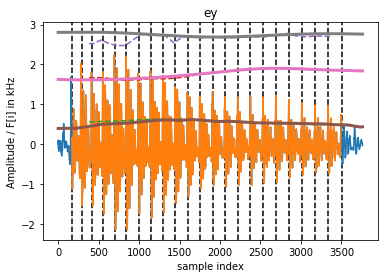

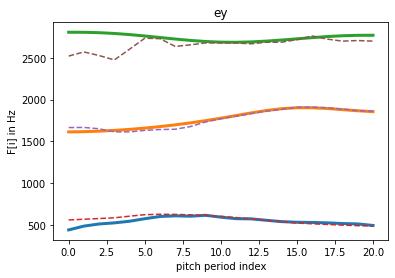

In [8]:
from lib import constants

for T_praat, F_true_periods, F_praat_periods, context in formant.yield_training_data(
        fb_file, phn_file, wav_file, return_full=True
    ):
    vowel = context['vowel']
    print("*"*10 + vowel + "*"*10)
    
    # Plot pulse estimates
    pulse_idx = context['pulse_idx']
    for pi in pulse_idx:
        axvline(pi, ls="--", color="black")
    first, last = pulse_idx[0], pulse_idx[-1]
    
    # Plot waveform
    segment = context['segment']
    plot(segment)
    plot(range(first, last), segment[first:last])
    
    # Plot formant tracks
    plot(context['F_praat_tracks']/1000, "--")
    plot(context['F_true_tracks']/1000, lw=3)
    ylabel("Amplitude / F[i] in kHz")
    xlabel("sample index")
    title(vowel)
    show()
    
    # Plot the distilled training data
    plot(F_true_periods, lw=3)
    plot(F_praat_periods, "--")
    ylabel("F[i] in Hz")
    xlabel("pitch period index")
    title(vowel)
    show()

## Getting the training pairs

Remember, we use TIMIT/TRAIN directories so we can use testing on the TIMIT/TEST files.

With our procedure, there are ~3000 valid training pairs which are typically around 10 pitch periods long with a heavy tail. Same order as the number of samples in our subset of APLAWD (5000).

In [9]:
%%time
training_data = formant.get_vtrformants_training_data()

[Memory]41.8s, 0.7min   : Loading get_vtrformants_training_data...
CPU times: user 327 ms, sys: 0 ns, total: 327 ms
Wall time: 325 ms


In [10]:
praat_T = training_data['praat_T']
true_F_trajectories = training_data['true_F_trajectories']
praat_F_trajectories = training_data['praat_F_trajectories']

In [11]:
pplens = np.array([sample.shape[0] for sample in true_F_trajectories])

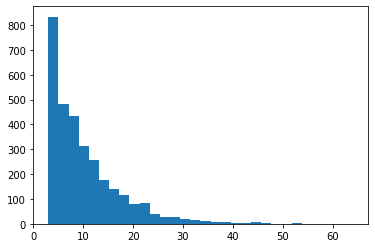

In [12]:
hist(pplens, bins=30);

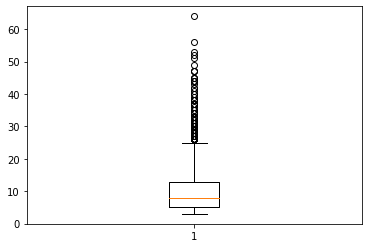

In [13]:
boxplot(pplens);

[ 565.98587094 1653.39062878 2589.33590221]


(188.89874537874545, 4871.85024560401)

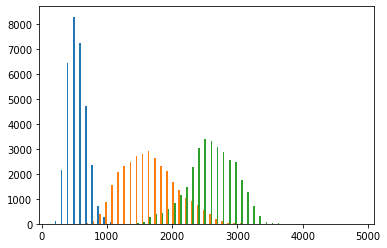

In [14]:
def process(traj):
    x = np.vstack(traj)
    hist(x, bins=50);
    print(mean(x, axis=0))
    return np.min(x), np.max(x)

process(true_F_trajectories)

[ 634.43485638 1711.4056669  2780.81781959]


(216.91514969887916, 4875.443197298808)

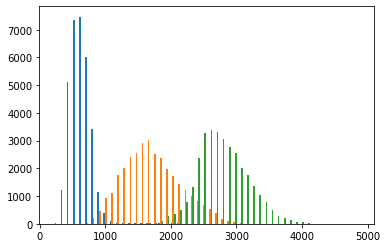

In [15]:
process(praat_F_trajectories)

## Fitting trajectory priors

All runs take O(45) mins.

Matern32Kernel wins, with the same pattern as with the period trajectory:

- Lengthscales decrease strongly as $\nu = 1/2, 3/2, 5/2, \infty$ increases, and noise $\sigma$ increases.
- There is a strong maximum of $\log Z(\nu)$ at $\nu = 3/2$.
- There is a definite preference for the degree of smoothness (or roughness) provided by $\nu=3/2$: not too much, not too little.
- There is also a definite preferences for a lengthscale $\lambda(\nu=3/2) \simeq 15$, which is quite large, but about halfof the lengthscale for the period ($\sim 30$ pitch periods). This seems right; pitch tracks usually move slower than formant tracks.

Very small $\sigma(\nu=3/2) \simeq 0.01$ indicates very good fit. But remember, we cherry-picked all the 3094 samples for vowels. Not steady-state (since a lengthscale of 15 pitch periods is preferred) but not too wild either.

The nested sampling fits are very sharp and support the maximum likelihood approximation.

In [16]:
bounds = jnp.array([
    (100., 5000.),
    (100., 5000.),
    (100., 5000.)
])

bounds

DeviceArray([[ 100., 5000.],
             [ 100., 5000.],
             [ 100., 5000.]], dtype=float64)

In [17]:
from lib import util
NAMES = ("s1", "s2", "s3", "lengthscale", "noise_sigma")

[Memory]44.4s, 0.7min   : Loading run_nested...
Summary
nlive: 25
niter: 883
ncall: 16771
eff(%):  5.414
logz: -482458.992 +/-  1.092


None

'Information (bans)'

12.39643350757592

Quantiles:
s1 [(0.025, 1.1267834438579685), (0.5, 1.1439595007718566), (0.975, 1.1627041904386701)]
Quantiles:
s2 [(0.025, 0.9305334040082083), (0.5, 0.9437283217360487), (0.975, 0.9577427554100048)]
Quantiles:
s3 [(0.025, 0.9709002029744488), (0.5, 0.9866911033996321), (0.975, 1.0027865845800499)]
Quantiles:
lengthscale [(0.025, 171.1520216882185), (0.5, 176.0714195614432), (0.975, 180.94426026424642)]
Quantiles:
noise_sigma [(0.025, 7.229053287760507e-05), (0.5, 0.0003171469961886348), (0.975, 0.0008140339494897411)]


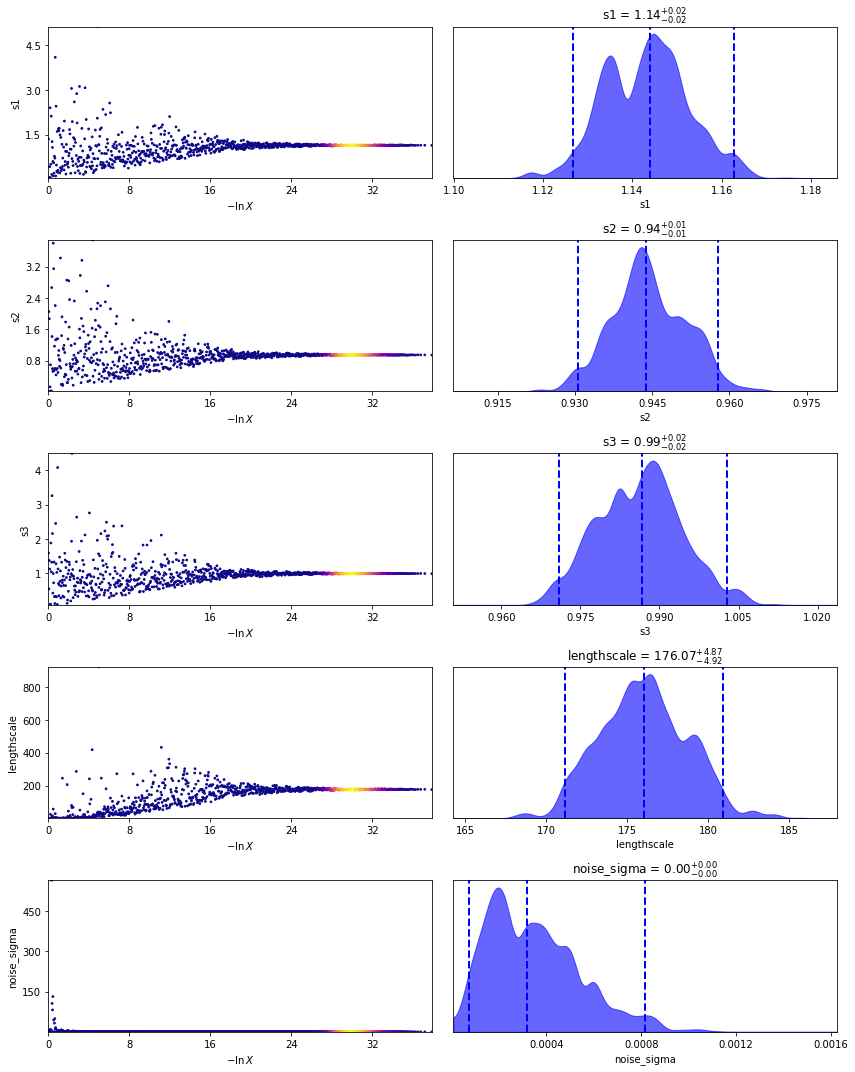

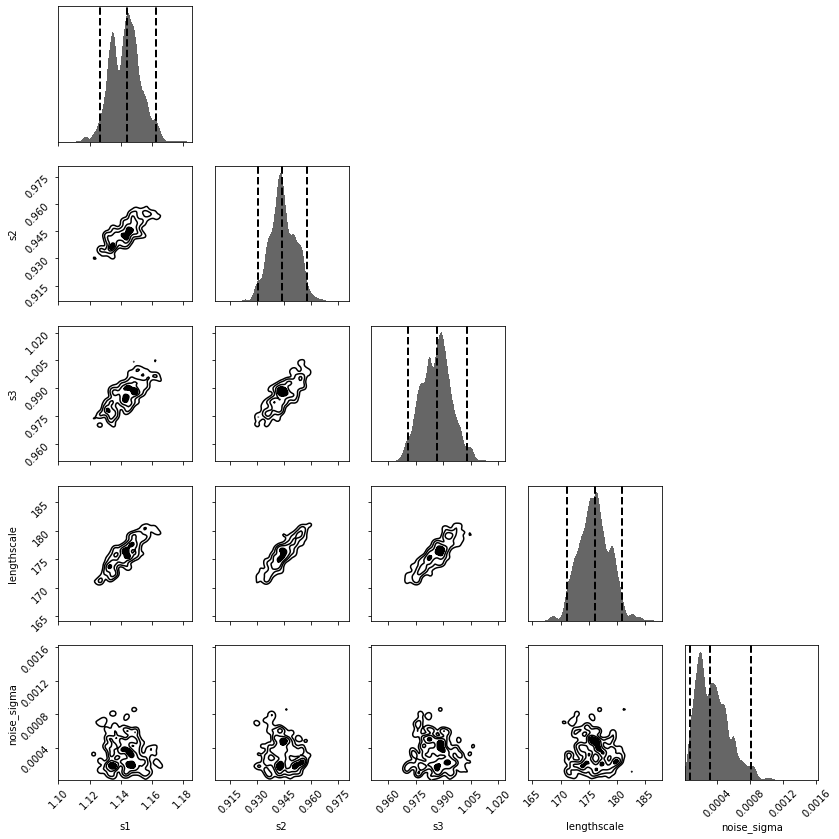

CPU times: user 8.71 s, sys: 1.99 s, total: 10.7 s
Wall time: 7.02 s


In [18]:
%%time
bijector, results = bijectors.fit_nonlinear_coloring_trajectory_bijector(
    true_F_trajectories, bounds, "Matern12Kernel", 23654862, return_fit_results=True
)
util.dyplot(results, NAMES)

[Memory]51.3s, 0.9min   : Loading run_nested...
Summary
nlive: 25
niter: 857
ncall: 13439
eff(%):  6.563
logz: -443868.740 +/-  1.085


None

'Information (bans)'

12.160931651187159

Quantiles:
s1 [(0.025, 1.389899071330358), (0.5, 1.4100146962688667), (0.975, 1.4278920280406469)]
Quantiles:
s2 [(0.025, 0.8120014589947236), (0.5, 0.8220506273983672), (0.975, 0.8307121167259309)]
Quantiles:
s3 [(0.025, 1.1646184193135938), (0.5, 1.178071199329176), (0.975, 1.197448029520175)]
Quantiles:
lengthscale [(0.025, 15.084133322828995), (0.5, 15.223383768828308), (0.975, 15.39264192357508)]
Quantiles:
noise_sigma [(0.025, 0.008537065943623752), (0.5, 0.008803747385457876), (0.975, 0.00917517858957503)]


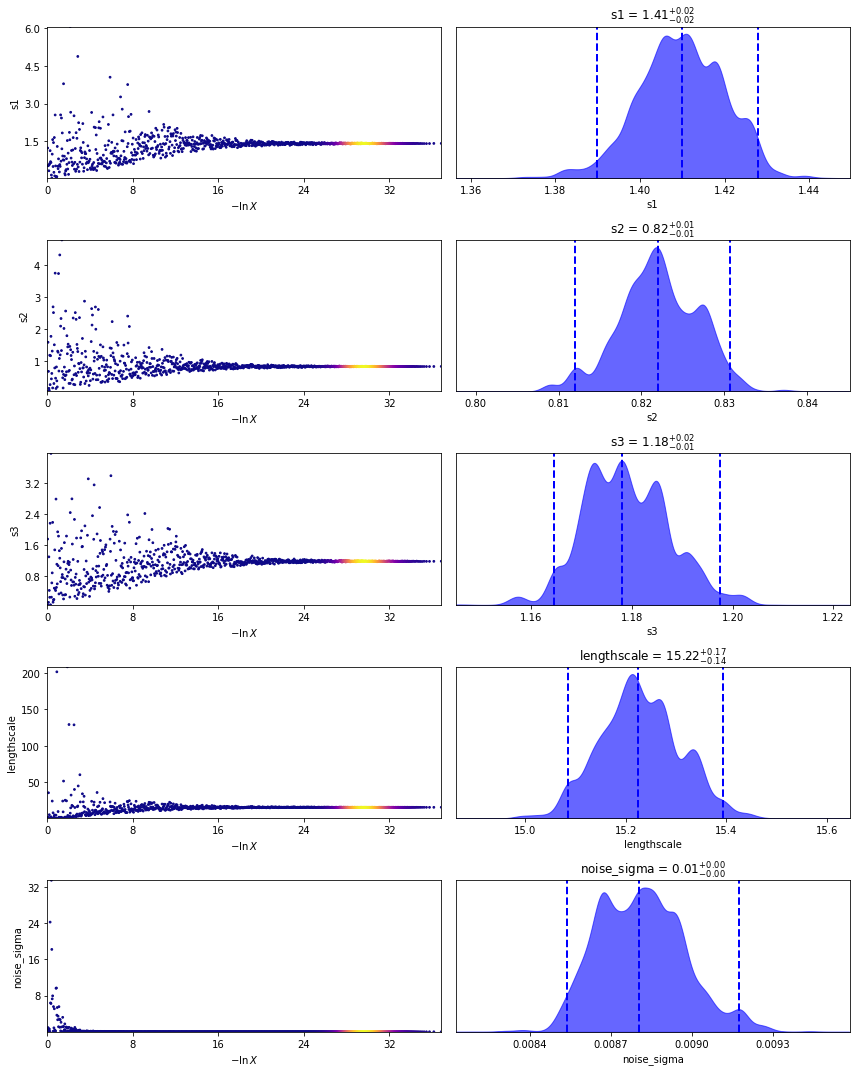

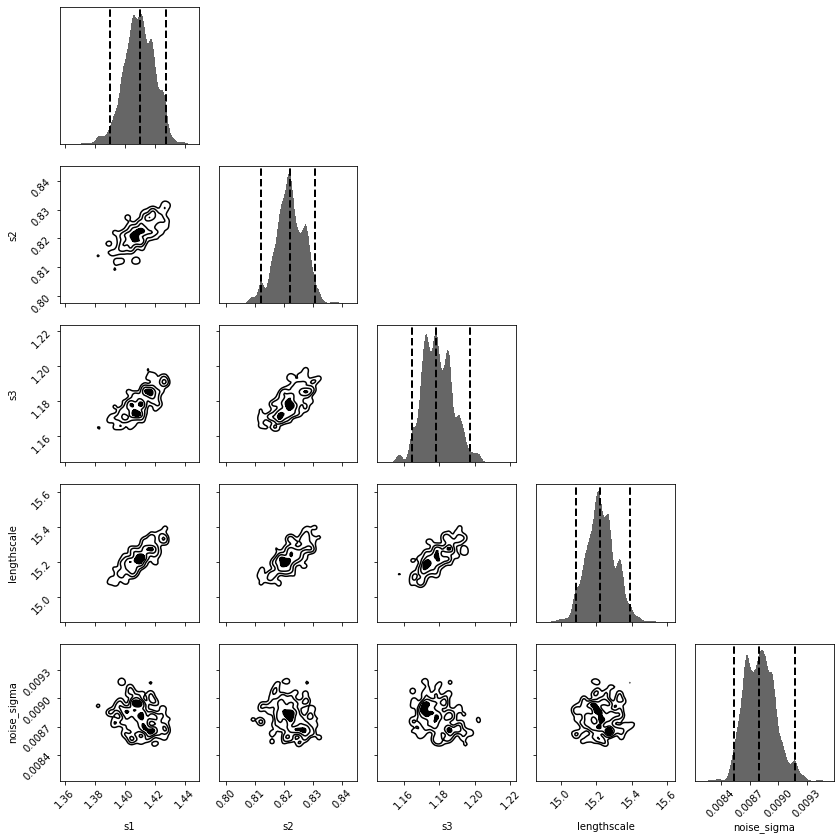

CPU times: user 8.21 s, sys: 1.68 s, total: 9.89 s
Wall time: 6.5 s


In [19]:
%%time
# alternatively cacheid=111111
bijector, results = bijectors.fit_nonlinear_coloring_trajectory_bijector(
    true_F_trajectories, bounds, "Matern32Kernel", 899785662, return_fit_results=True
)
util.dyplot(results, NAMES)

[Memory]57.8s, 1.0min   : Loading run_nested...
Summary
nlive: 25
niter: 841
ncall: 14686
eff(%):  5.897
logz: -443868.144 +/-  1.071


None

'Information (bans)'

11.81848570730299

Quantiles:
s1 [(0.025, 1.3896783552848493), (0.5, 1.4083227694387734), (0.975, 1.4273496799810852)]
Quantiles:
s2 [(0.025, 0.8124092721938062), (0.5, 0.8217732100709931), (0.975, 0.8332642791813198)]
Quantiles:
s3 [(0.025, 1.1620895692698674), (0.5, 1.176550360240356), (0.975, 1.195611863214868)]
Quantiles:
lengthscale [(0.025, 15.05609523341872), (0.5, 15.208341927969345), (0.975, 15.380301111398078)]
Quantiles:
noise_sigma [(0.025, 0.00856171648357472), (0.5, 0.00883893154444583), (0.975, 0.009168513713046372)]


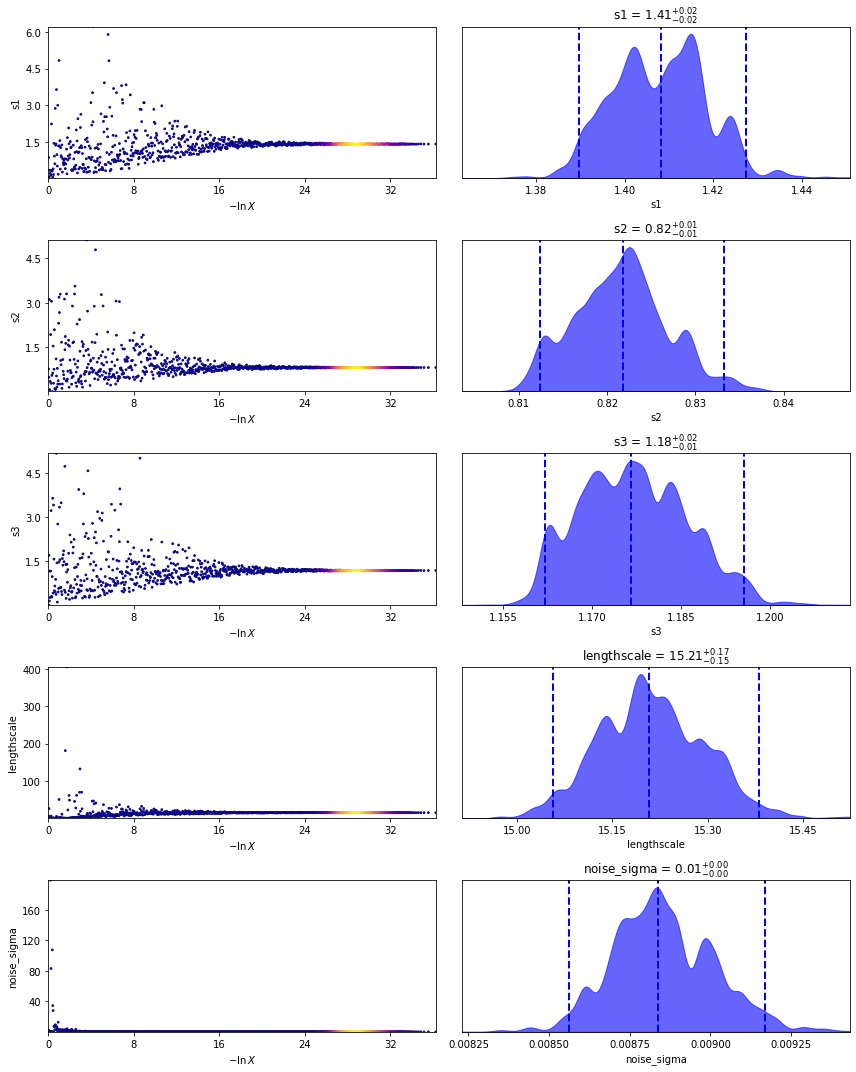

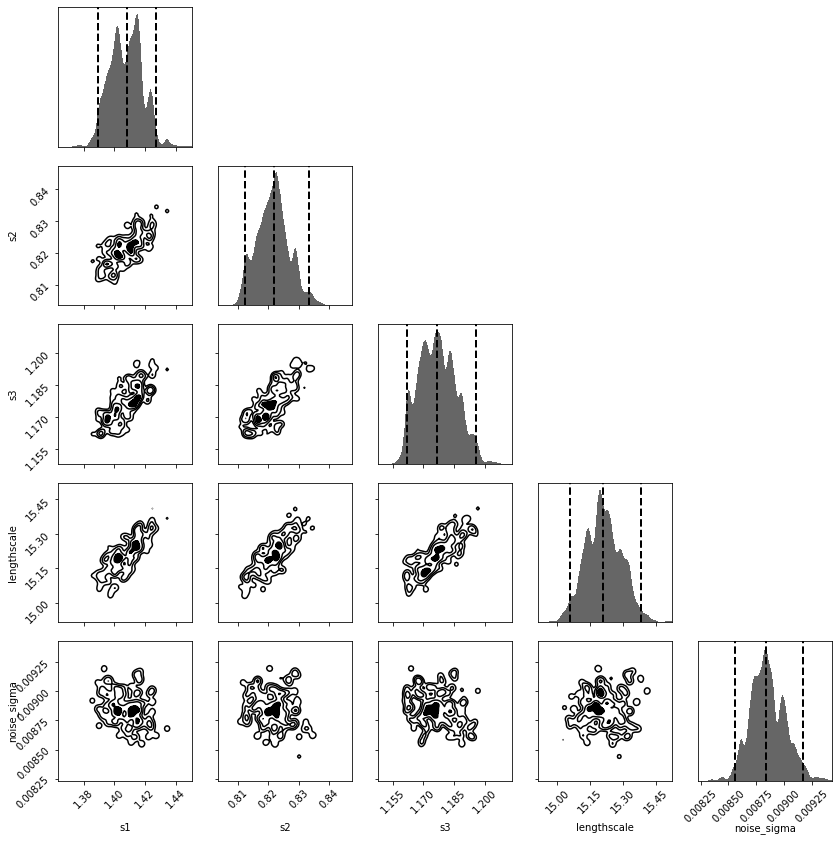

In [20]:
# **********************MATERN32 AGAIN**********************
bijector, results = bijectors.fit_nonlinear_coloring_trajectory_bijector(
    true_F_trajectories, bounds, "Matern32Kernel", 111111, return_fit_results=True
)
util.dyplot(results, NAMES)

[Memory]63.8s, 1.1min   : Loading run_nested...
Summary
nlive: 25
niter: 851
ncall: 14218
eff(%):  6.161
logz: -447988.917 +/-  1.077


None

'Information (bans)'

11.987647292058154

Quantiles:
s1 [(0.025, 1.2567497983272553), (0.5, 1.2735654439872799), (0.975, 1.2885218821482234)]
Quantiles:
s2 [(0.025, 0.7267436683135456), (0.5, 0.734380108396959), (0.975, 0.7418855956390723)]
Quantiles:
s3 [(0.025, 1.038581543848726), (0.5, 1.052198530217803), (0.975, 1.0672610033870586)]
Quantiles:
lengthscale [(0.025, 8.161982831435074), (0.5, 8.22207516788918), (0.975, 8.278833020462105)]
Quantiles:
noise_sigma [(0.025, 0.017697102997323647), (0.5, 0.017978038909467024), (0.975, 0.018264774814937473)]


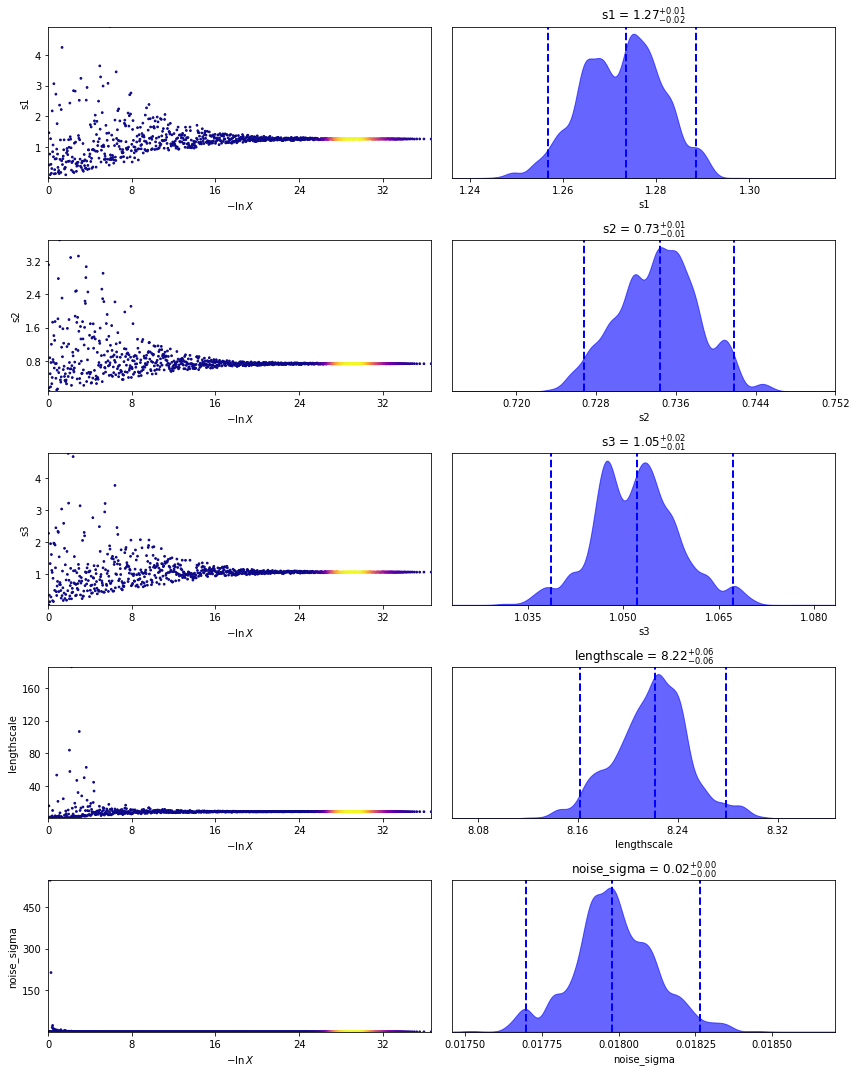

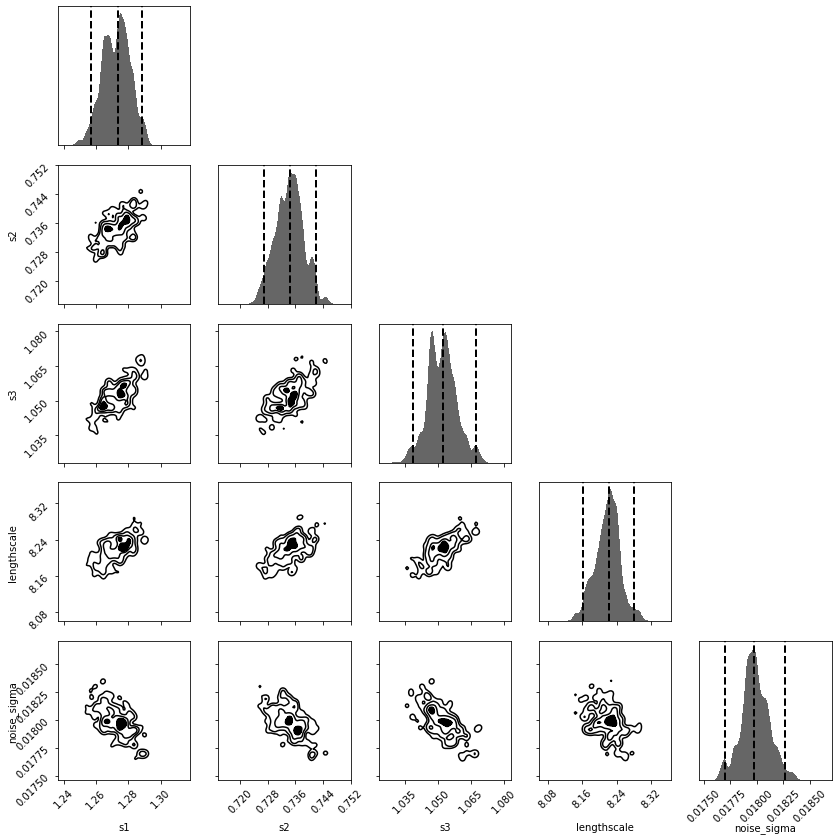

CPU times: user 8.03 s, sys: 1.72 s, total: 9.75 s
Wall time: 6.43 s


In [21]:
%%time
bijector, results = bijectors.fit_nonlinear_coloring_trajectory_bijector(
    true_F_trajectories, bounds, "Matern52Kernel", 17893652, return_fit_results=True
)
util.dyplot(results, NAMES)

[Memory]70.3s, 1.2min   : Loading run_nested...
Summary
nlive: 25
niter: 871
ncall: 14237
eff(%):  6.293
logz: -464147.140 +/-  1.092


None

'Information (bans)'

12.305801533143152

Quantiles:
s1 [(0.025, 1.1038424626335586), (0.5, 1.1165149474319784), (0.975, 1.1295348103447205)]
Quantiles:
s2 [(0.025, 0.6789729668322098), (0.5, 0.6844284088279794), (0.975, 0.6906518781021824)]
Quantiles:
s3 [(0.025, 0.9893023557261046), (0.5, 1.0010993865615236), (0.975, 1.0126303104962393)]
Quantiles:
lengthscale [(0.025, 4.282314977817972), (0.5, 4.313978912194783), (0.975, 4.350838777676627)]
Quantiles:
noise_sigma [(0.025, 0.029592880147944277), (0.5, 0.0300116597720468), (0.975, 0.030413202366529408)]


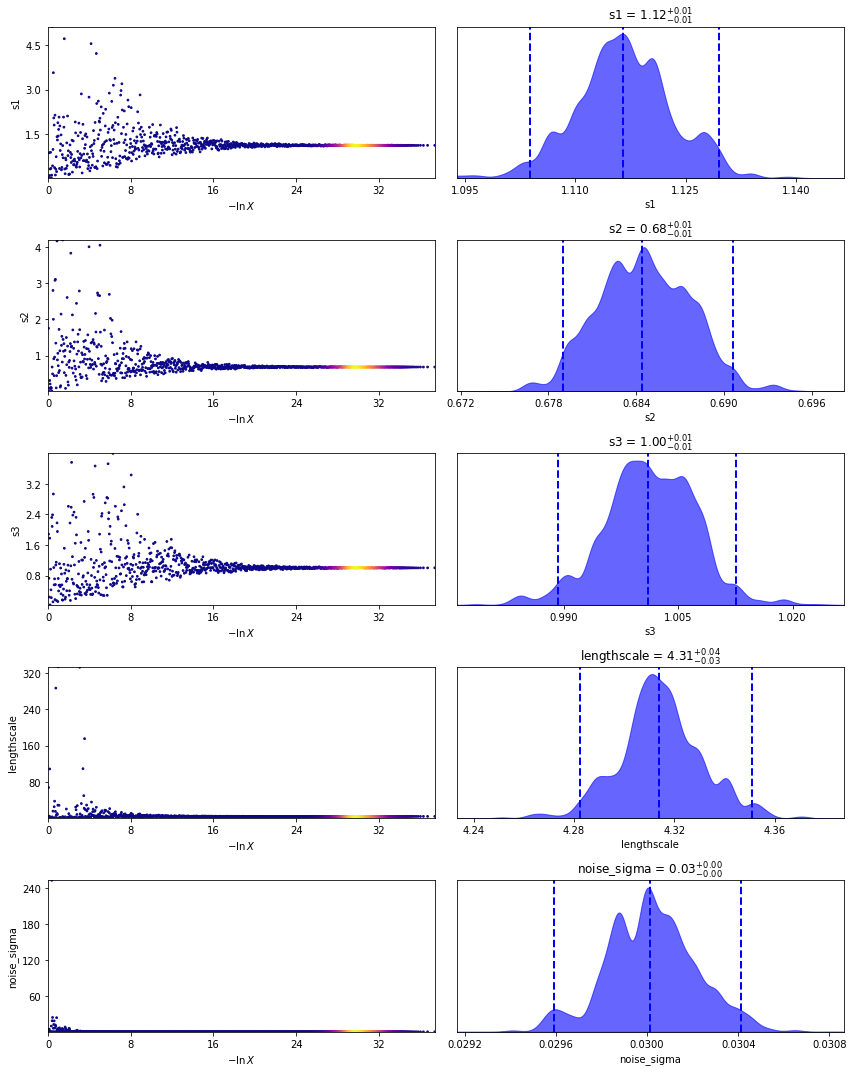

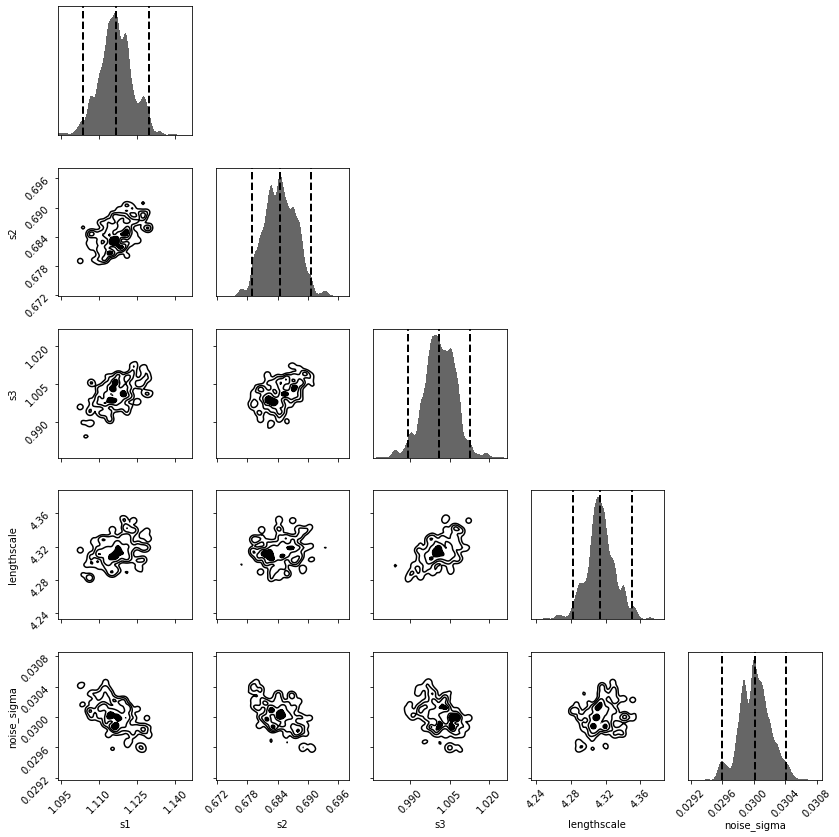

CPU times: user 7.93 s, sys: 1.6 s, total: 9.52 s
Wall time: 6.18 s


In [22]:
%%time
bijector, results = bijectors.fit_nonlinear_coloring_trajectory_bijector(
    true_F_trajectories, bounds, "SqExponentialKernel", 9856723, return_fit_results=True
)
util.dyplot(results, NAMES)

## Check the best fit

Unlike for the period prior, there is a considerable non-zero mean component to the error in the colored (log) domain.

For F1 this is about 10% relative error **overestimation**, because we define $$(\text{observed estimate}) = \text{true} + \text{error}$$. This is likely caused by the fact that Praat sometimes "forgets" F2 and assigns its F2 already to the true F3 -- indeed all error means are positive, so Praat tends to overestimate the formants. We could use Student-t's to deal with this situation a bit better, but it's only a prior. Below we show that our prior can predict the real $F$ trajectories quite well given Praat's estimates, especially the smoothness of the real $F$ trajectories.

In [23]:
praat_mean, praat_cov = formant.fit_praat_estimation_mean_and_cov()

In [24]:
praat_mean # non-zero mean

DeviceArray([0.11528354, 0.03432305, 0.07409751], dtype=float64)

The standard deviation of F1 is comparable to its mean!

In [25]:
sqrt(diag(praat_cov))

array([0.19248338, 0.16251466, 0.17963905])

Together with mean values for F1, F2, F3 = (560, 1650, 2600) (see `process()` above), this gives ballpark error estimates comparable to Mehta (2012) Table III.

For example: F1 error = (0.11 relative error +/- 1 sigma 0.19 relative rror) X (F1 mean) = 0.3 X (F1 mean) = 187 Hz and Mehta gives 185 Hz (the strong similarity is just a coincidence).

Strong upward correlations -- if one error is unusually large, so are others. These is probably another effect caused by Praat's misassigning of F2 to F3, which upsets the whole estimation. But it is good our prior can take this situation -- if imperfectly -- into account.

In [26]:
util.correlationmatrix(praat_cov)

DeviceArray([[1.        , 0.46090671, 0.34737051],
             [0.46090671, 1.        , 0.50750041],
             [0.34737051, 0.50750041, 1.        ]], dtype=float64)

## Check conditioning

In [27]:
b = formant.fit_formants_trajectory_bijector()

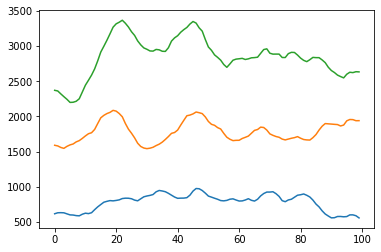

In [28]:
npp = 100
F = b(npp).forward(randn(3*npp))
plot(F)

DeviceArray([[0.03704985, 0.01441779, 0.01201121],
             [0.01441779, 0.02641101, 0.01481596],
             [0.01201121, 0.01481596, 0.03227019]], dtype=float64)

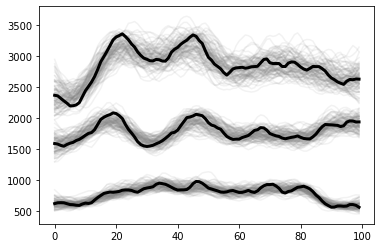

In [29]:
def trycov(cov):
    display(cov)
    cb = bijectors.condition_nonlinear_coloring_trajectory_bijector(
        b(npp), F, cov, praat_mean
    )
    for _ in range(100):
        Fc = cb.forward(randn(3*npp))
        plot(Fc, color="grey", alpha=0.1)
        
    plot(F, lw=3, color="black")
    return locals()
trycov(praat_cov);

DeviceArray([[0.00370499, 0.00144178, 0.00120112],
             [0.00144178, 0.0026411 , 0.0014816 ],
             [0.00120112, 0.0014816 , 0.00322702]], dtype=float64)

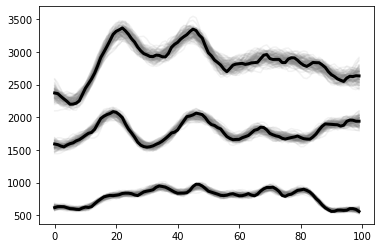

In [30]:
trycov(praat_cov*0.1);

DeviceArray([[0.37049853, 0.14417794, 0.12011215],
             [0.14417794, 0.26411014, 0.14815956],
             [0.12011215, 0.14815956, 0.32270187]], dtype=float64)

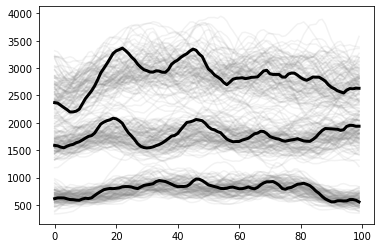

In [31]:
trycov(praat_cov*10.);

## Conditioning: compare prior to database

Plot samples from the database and see whether the true F values are predicted well from our prior.

Conclusion: overall good performance, and quite often the true F values are more probable than Praat's estimates. Nevertheless, sometimes Praat gets the estimates catastrophically wrong (basically it assigns F2 to the real F3) and our prior cannot cope with that, even though we use the mean of the errors (= +10% relative percent overestimation of true value).

**********ih**********
log p(True) = -57.36844652357447
log p(True|Estimate) = -54.04396550482525
log p(Estimate|Estimate) = -51.33114606757779


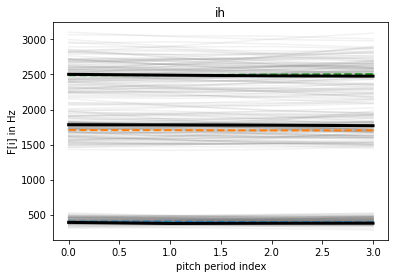

/home/marnix/WRK/thesis/py/vtr/prior/formant.py:90: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR6/MESJ0/SI2039.WAV: Discarding vowel `ix` segment at sample indices 5410:5973: segment too short for Praat's pulse estimation algorithm: To analyse this Sound, “minimum pitch” must not be less than 85.25754884547068 Hz.
Sound: pitch analysis not performed.
  warnings.warn(


**********ih**********
log p(True) = -44.488154722108895
log p(True|Estimate) = -44.24820806595726
log p(Estimate|Estimate) = -40.95721043526351


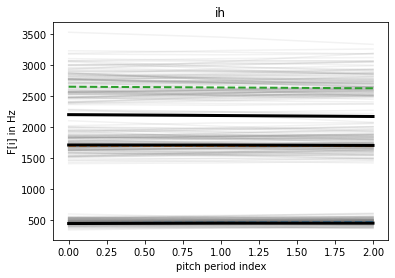

**********iy**********
log p(True) = -76.65917267268799
log p(True|Estimate) = -76.23766161451255
log p(Estimate|Estimate) = -77.47255154388715


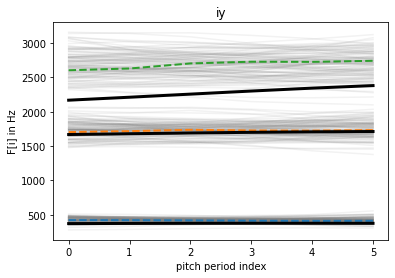

/home/marnix/WRK/thesis/py/vtr/prior/formant.py:90: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR6/MESJ0/SI2039.WAV: Discarding vowel `ih` segment at sample indices 11362:12198: Praat gave only 1 < 3 valid formants
  warnings.warn(


**********eh**********
log p(True) = -44.18189656202498
log p(True|Estimate) = -42.41257307639485
log p(Estimate|Estimate) = -40.67136594870354


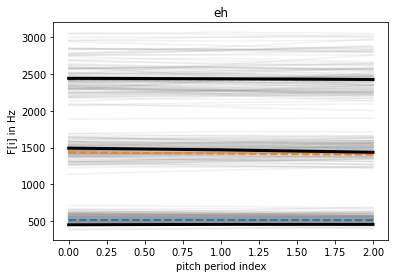

**********ao**********
log p(True) = -140.2404670734141
log p(True|Estimate) = -369.10286996149443
log p(Estimate|Estimate) = -208.23116722247136


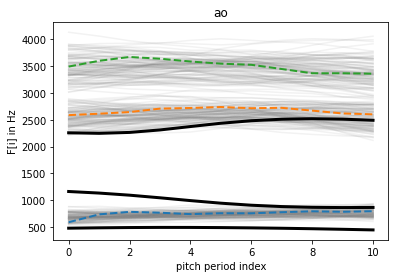

/home/marnix/WRK/thesis/py/vtr/prior/formant.py:90: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR6/MESJ0/SI2039.WAV: Discarding vowel `ax` segment at sample indices 19000:19720: segment too short for Praat's pulse estimation algorithm: No times in PointProcess.
PointProcess "untitled_untitled": not converted to Matrix.
  warnings.warn(
/home/marnix/WRK/thesis/py/vtr/prior/formant.py:90: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR6/MESJ0/SI2039.WAV: Discarding vowel `ih` segment at sample indices 22240:23060: Praat gave only 2 < 3 valid formants
  warnings.warn(
/home/marnix/WRK/thesis/py/vtr/prior/formant.py:90: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR6/MESJ0/SI2039.WAV: Discarding vowel `eh` segment at sample indices 26370:28550: Estimated Praat periods not within `{min|max}_period_length_msec`: [2.     2.4375 2.5625 2.3125 2.     2.0625 2.     2.0625 2.     1.9375
 1.9375 1.9375 2.0625 2.     2.3125 2.5625 2.     2.0625 2.0625

**********ey**********
log p(True) = -181.90838577057986
log p(True|Estimate) = -176.1970834558068
log p(Estimate|Estimate) = -185.52361589092732


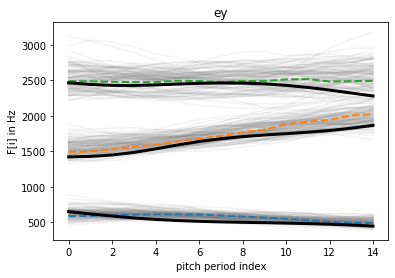

**********uh**********
log p(True) = -73.47701814327746
log p(True|Estimate) = -115.12256152334618
log p(Estimate|Estimate) = -2197.100318159366


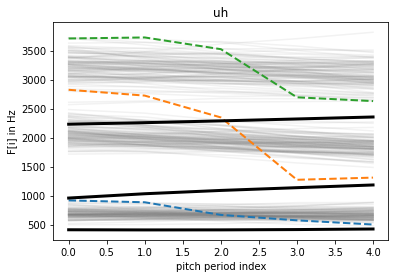

/home/marnix/WRK/thesis/py/vtr/prior/formant.py:90: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR6/MESJ0/SI2039.WAV: Discarding vowel `ax` segment at sample indices 46330:46749: segment too short for Praat's pulse estimation algorithm: To analyse this Sound, “minimum pitch” must not be less than 114.55847255369929 Hz.
Sound: pitch analysis not performed.
  warnings.warn(


**********ey**********


In [ ]:
fb_file, phn_file, wav_file = rand_triple()

for T_praat, F_true_periods, F_praat_periods, context in formant.yield_training_data(
        fb_file, phn_file, wav_file, return_full=True
    ):
    vowel = context['vowel']
    print("*"*10 + vowel + "*"*10)
    
    # Plot the guesses for the true trajectory given Praat's estimate
    num_pitch_periods = len(F_true_periods)
    prior = formant.formants_trajectory_prior(
        num_pitch_periods, F_praat_periods
    )
    
    blind_prior = formant.formants_trajectory_prior(
        num_pitch_periods
    )
    
    samples = prior.sample(100, seed=jaxkey())
    for s in samples:
        plot(s, color="grey", alpha=0.1)
    
    print("log p(True) =", blind_prior.log_prob(F_true_periods))
    print("log p(True|Estimate) =", prior.log_prob(F_true_periods))
    print("log p(Estimate|Estimate) =", prior.log_prob(F_praat_periods))
    
    # Plot the distilled training data
    plot(F_praat_periods, "--", lw=2)
    plot(F_true_periods, lw=3, color="black")
    ylabel("F[i] in Hz")
    xlabel("pitch period index")
    title(vowel)
    show()